# Toy topology and signals dataset

In [1]:
import numpy as np 
from itertools import combinations
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# Fourier basis + Canonical basis

def FB(D:int,
       over = False): 

    k = np.arange(D).reshape((D, 1))
    n = np.arange(D).reshape((1, D))

    if over:
        return np.hstack([(1/np.sqrt(D)) * np.exp(-2j * np.pi * k * n / D), np.eye(D)])
    else:
        return (1/np.sqrt(D)) * np.exp(-2j * np.pi * k * n / D)

In [3]:
def subSpaceAssignment(N:int,
                       D:int,
                       K:int):
    
    combo = list(combinations(range(D), K))
    patterns = np.random.choice(len(combo), N, replace=True)
    return {n: np.array(combo[patterns[n]], dtype = 'int32') for n in range(N)}

In [4]:
def premultiplier(Xu, Xv):
    uu = np.linalg.pinv(Xu @ Xu.T)
    uv = Xu @ Xv.T
    vv = np.linalg.pinv(Xv @ Xv.T)
    vu = Xv @ Xu.T

    return (uu, uv, vv, vu)

def chi_u(uu, uv, vv, vu):

    return ((uu @ uv - np.eye(uu.shape[0])) @ vv @ np.linalg.pinv(vu @ uu @ uv @ vv - np.eye(uu.shape[0])) @ vu - np.eye(uu.shape[0])) @ uu

def chi_v(uu, uv, vv, vu):

    return (uu @ uv - np.eye(uu.shape[0])) @ vv @ np.linalg.pinv(vu @ uu @ uv @ vv - np.eye(uu.shape[0]))

________________

In [5]:
V = 4
edges = [
    (0,1),
    (1,2),
    (1,3),
    (0,2)
]

nodes = [i for i in range(V)]
E = len(edges)

In [49]:
d = 20
k = 5
N = 100000

In [50]:
D = FB(d)

In [82]:
subspaces = {0:np.array([0,1,2,3]),
             1:np.array([3,4,5,6]),
             2:np.array([1,2,3,4]),
             3:np.array([6,7,8,9])}

In [84]:
signals = {node: D[:,subspaces[node]] @ np.random.randn(4, N) + np.random.randn(d,N)*0.01
           for node in nodes}

In [85]:
signals[0].shape

(20, 100000)

In [86]:
T = 0

H = {
    edge : {
        edge[0] : None,
        edge[1] : None
    }
for edge in combinations(nodes, 2)
}

In [87]:
for e in tqdm(combinations(nodes,2)):
    u = e[0]
    v = e[1]

    X_u = signals[u]
    X_v = signals[v]
    uu, uv, vv, vu = premultiplier(X_u, X_v)

    H[e][u] = chi_u(uu, uv, vv, vu)
    H[e][v] = chi_u(uu, uv, vv, vu)
    
    T += np.trace(H[e][u]) + np.trace(H[e][v])

0it [00:00, ?it/s]

6it [00:00, 29.87it/s]


In [88]:
mu = T

In [89]:
H = {
    edge : {
        edge[0] : mu/T * (H[edge][edge[0]]),
        edge[1] : mu/T * (H[edge][edge[1]])
    }
for edge in combinations(nodes, 2)
}

In [90]:
all_edges = list(combinations(range(V), 2))

energies = {
    e : 0
    for e in all_edges
    }

for e in (all_edges):
    u = e[0]
    v = e[1]
    
    '''
    X_ = np.zeros_like(X)
    X_[u*d:(u+1)*d,:] = X[u*d:(u+1)*d,:]
    X_[v*d:(v+1)*d,:] = X[v*d:(v+1)*d,:]
    energies[e] = np.linalg.norm(BB @ X_)
    '''

    energies[e] = np.linalg.norm(H[e][e[0]] @ signals[e[0]] - H[e][e[1]] @ signals[e[1]])

In [91]:
retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]

In [92]:
print(f'Accuracy in retrieving underlying graph {len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E}')

Accuracy in retrieving underlying graph 0.75


In [93]:
retrieved

[((0, 1), 290.1642714844936),
 ((1, 3), 307.72964894277897),
 ((0, 3), 330.3506983609606),
 ((0, 2), 465.0161100630276)]

_______________

In [19]:
def simulation(V,
               edges,
               d,
               N,
               S):
    
    V = 4
    accs = np.zeros((S, d))
    E = len(edges)
    for it in tqdm(range(S)):
                
        for k in range(1,d):
            subs = subSpaceAssignment(V, int(d), int(k))

            signals = {node: D[:,subs[node]] @ np.random.randn(k, N)
                for node in range(V)}
            
            T = 0

            H = {
                edge : {
                    edge[0] : None,
                    edge[1] : None
                }
            for edge in combinations(range(V), 2)
            }

            for e in combinations(range(V),2):
                u = e[0]
                v = e[1]

                X_u = signals[u]
                X_v = signals[v]
                uu, uv, vv, vu = premultiplier(X_u, X_v)

                H[e][u] = chi_u(uu, uv, vv, vu)
                H[e][v] = chi_u(uu, uv, vv, vu)
                
                T += np.trace(H[e][u]) + np.trace(H[e][v])

            mu = T

            H = {
            edge : {
                edge[0] : mu/T * (H[edge][edge[0]]),
                edge[1] : mu/T * (H[edge][edge[1]])
            }
            for edge in combinations(nodes, 2)
            }

            all_edges = list(combinations(range(V), 2))

            energies = {
                e : 0
                for e in all_edges
                }

            for e in (all_edges):
                u = e[0]
                v = e[1]
        
                '''
                X_ = np.zeros_like(X)
                X_[u*d:(u+1)*d,:] = X[u*d:(u+1)*d,:]
                X_[v*d:(v+1)*d,:] = X[v*d:(v+1)*d,:]
                energies[e] = np.linalg.norm(BB @ X_)
                '''

                energies[e] = np.linalg.norm(H[e][e[0]] @ signals[e[0]] - H[e][e[1]] @ signals[e[1]])

            retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]
            accs[it,k] =len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E

    return accs

In [ ]:
accs = simulation(V, edges, 20, 100, 100)

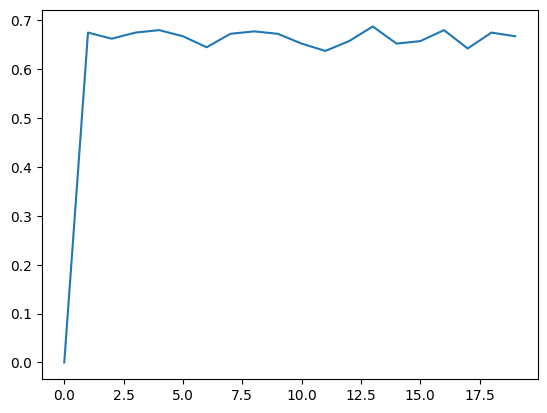

In [ ]:
plt.plot(np.mean(accs, axis = 0))